In [1]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from operator import itemgetter
import pickle
from scipy.stats import skew, boxcox
from datetime import datetime
import matplotlib.pyplot as plt
#import plotly.plotly as py
#py.sign_in('rezaul_abedin', 'Abedin228')
#import plotly.graph_objs as go
from sklearn.model_selection import learning_curve, GridSearchCV
#from sklearn.grid_search import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from sklearn.metrics import make_scorer
import time
start = time.clock()
print('Started!')

Started!


C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print(' Time taken: %i minutes and %s seconds.' %
              (tmin, round(tsec, 2)))


In [3]:
def get_date_features():
    pkl_file = open('D:/Project/Sample_data_4/output4/train_date_df.pkl', 'rb')
    
    traindata = pickle.load(pkl_file)
        
    return ['Id'] + list(traindata.columns)
        
usefuldatefeatures = get_date_features()


In [4]:
len(usefuldatefeatures)

1157

In [17]:
train

NameError: name 'train_date' is not defined

In [5]:
def get_date():
    ## get the data plus do some feature engineering
    trainfile = 'D:/Project/Sample_data_4/Sam_4/train_date.csv'# without mean
    testfile = 'D:/Project/Sample_data_4/Sam_Test_4/test_date.csv'# without mean
  
    train = pd.read_csv(trainfile, usecols=usefuldatefeatures)
    features = list(train.columns)
    features.remove('Id')
    df_train = train[['Id']].copy()
    print(df_train.head)
    df_train['mindate'] = train[features].min(axis=1).values
    
    #print (train[features].min(axis=1).values)
    #print (df_train.head())
    
    df_train['maxdate'] = train[features].max(axis=1).values
    df_train['meandate'] = train[features].mean(axis=1).values

    
    df_train['mean_vs_min_diff']=df_train['meandate'] - df_train['mindate']
    df_train['max_vs_mean_diff']=df_train['maxdate'] - df_train['meandate']
    #print (df_train.head())
    df_train['diff'] = df_train['maxdate'] - df_train['mindate']    
    
    #print (df_train.head())
        
    test = pd.read_csv(testfile, usecols=usefuldatefeatures)
    df_test = test[['Id']].copy()
    df_test['mindate'] = test[features].min(axis=1).values
    df_test['maxdate'] = test[features].max(axis=1).values 
    df_test['diff'] = df_test['maxdate'] - df_test['mindate']
        
    df = pd.concat([df_train, df_test])     
    df.sort_values(by=['mindate', 'Id'], inplace=True)
    
    #print(df.head())
    
    df['df_id_diff'] = df.Id.diff()
    #print(df.Id.diff())
    rew = np.full_like(df.df_id_diff.values, np.nan)
    #print(rew)
    rew[0:-1] = -df.df_id_diff.values[1:]
    #print (df.df_id_diff.values[1:])
    df['df_id_diff_reverse'] = rew
        
    return df

In [6]:
trainfile = 'D:/Project/Sample_data_4/Sam_4/train_date.csv'# without mean
testfile = 'D:/Project/Sample_data_4/Sam_Test_4/test_date.csv'# without mean

train = pd.read_csv(trainfile, usecols=usefuldatefeatures)
features = list(train.columns)
features.remove('Id')
df_train = train[['Id']].copy()


In [19]:
train

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,456,938.73,938.73,938.73,938.73,938.73,938.73,938.73,938.73,938.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2181,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3554,140.06,140.06,140.06,140.06,140.06,140.06,140.06,140.06,140.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4998,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5349,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
train.loc[train['Id'] == 1713209]

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,1713209,938.73,938.73,938.73,938.73,938.73,938.73,938.73,938.73,938.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1713209,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1713209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1713209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1713209,140.06,140.06,140.06,140.06,140.06,140.06,140.06,140.06,140.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1713209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1713209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1713209,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1713209,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1713209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df= get_date()

<bound method NDFrame.head of            Id
0         456
1        2181
2        2796
3        2943
4        3554
5        4017
6        4622
7        4998
8        5349
9        6799
10       8511
11       8531
12       8891
13       9852
14       9981
15      10148
16      10516
17      12898
18      13018
19      13575
20      13898
21      14177
22      14572
23      14784
24      16606
25      16890
26      16921
27      17210
28      17450
29      17551
...       ...
3970  2352259
3971  2352939
3972  2353131
3973  2353145
3974  2353477
3975  2353894
3976  2353898
3977  2354036
3978  2355057
3979  2355266
3980  2356158
3981  2356240
3982  2356519
3983  2356862
3984  2357564
3985  2358552
3986  2359426
3987  2359492
3988  2360863
3989  2361445
3990  2361511
3991  2362768
3992  2363252
3993  2363412
3994  2364507
3995  2364594
3996  2364816
3997  2364879
3998  2364941
3999  2365870

[4000 rows x 1 columns]>


C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
xx=train[features].min(axis=1).values

In [16]:
df

,Id,diff,max_vs_mean_diff,maxdate,mean_vs_min_diff,meandate,mindate,df_id_diff,df_id_diff_reverse
1372,834890,1.21,0.340407,1.62,0.869593,1.279593,0.41,NaN,41621.0
1283,793269,1.16,0.323600,1.60,0.836400,1.276400,0.44,-41621.0,-651266.0
2424,1444535,1.28,0.354286,1.74,0.925714,1.385714,0.46,651266.0,-268674.0
2893,1713209,0.44,NaN,1.05,NaN,NaN,0.61,268674.0,634622.0
1865,1078587,1.26,NaN,1.90,NaN,NaN,0.64,-634622.0,44204.0
1785,1034383,1.15,NaN,1.86,NaN,NaN,0.71,-44204.0,-13523.0
1798,1047906,1.19,NaN,1.93,NaN,NaN,0.74,13523.0,-46034.0
1805,1093940,0.23,0.173889,0.99,0.056111,0.816111,0.76,46034.0,323005.0
1331,770935,1.18,NaN,1.98,NaN,NaN,0.80,-323005.0,-944614.0
2900,1715549,1.31,NaN,2.28,NaN,NaN,0.97,944614.0,1184668.0


In [8]:
xx

array([ 938.73, 1092.63,  585.4 , ...,  805.7 ,  468.55,  236.76])

In [9]:
train.iloc[1:2, 1:train.shape[1]].min(axis=1).values

array([1092.63])

In [10]:
testfile = 'D:/Project/Sample_data_4/Sam_Test_4/test_date.csv'# without mean
df_tes = pd.read_csv(testfile)

In [11]:
train

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,456,938.73,938.73,938.73,938.73,938.73,938.73,938.73,938.73,938.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2181,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,1092.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3554,140.06,140.06,140.06,140.06,140.06,140.06,140.06,140.06,140.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4998,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,1600.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5349,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,1377.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
793269 -1444535

-651266

In [35]:
793269 -834890

-41621

In [14]:
'''def cat_date_preprosess(visible, blind, column_name):
    outcomes = visible.groupby(column_name)['Response'].mean().reset_index()
    x = pd.merge(blind[[column_name, 'Response']], outcomes,
                 suffixes=('_', ''),
                 how='left',
                 on=column_name,
                 left_index=True)['Response']
    return x.fillna(x.mean())
'''

In [23]:
def data():
   #trainfiles = ['D:/Project/Sample data/Sam_8/train_categorical.csv']
    trainfiles = ['D:/Project/Sample_data_4/Sam_4/train_categoricalWT.csv','D:/Project/Sample_data_4/Sam_4/train_date.csv','D:/Project/Sample_data_4/Sam_4/train_numeric.csv']
    #testfiles = ['D:/Project/Sample data/Sam_Test_8/test_categorical.csv']

    testfiles = ['D:/Project/Sample_data_4/Sam_Test_4/test_categoricalWT.csv','D:/Project/Sample_data_4/Sam_Test_4/test_date.csv', 'D:/Project/Sample_data_4/Sam_Test_4/test_numeric.csv']

    cols = [['Id',
             'L1_S24_F1559', 'L3_S32_F3851',
             'L1_S24_F1827', 'L1_S24_F1582',
             'L3_S32_F3854', 'L1_S24_F1510',
             #'L1_S24_F1525', 
             'L3_S29_F3481',
             'L2_S26_F3097', 'L2_S27_F3220',
             'L2_S27_F3192', 'L3_S29_F3493',
             #'L1_S24_F675', 
             'L3_S47_F4191',
            ],
            ['Id',
             'L3_S30_D3496', 'L3_S30_D3506',
             'L3_S30_D3501', 'L3_S30_D3516',
             'L3_S30_D3511', 'L3_S37_D3951',
             'L3_S34_D3883', 'L3_S47_D4190',
             'L3_S38_D3961', 'L3_S32_D3852',
             'L3_S29_D3480', 'L0_S4_D106',
             'L0_S3_D102',   'L3_S35_D3891',
             'L0_S1_D26',    #'L0_S21_D484',
             'L3_S36_D3940', 'L0_S16_D428', 
             'L3_S33_D3874', 'L3_S36_D3925',
             'L2_S26_D3096', 'L2_S27_D3219',
             'L0_S0_D23',    'L3_S29_D3492',
             'L0_S11_D328',  'L0_S10_D231', 

            ],
            ['Id',
             'L1_S24_F1846', 'L3_S32_F3850',
             'L1_S24_F1695', 'L1_S24_F1632',
             'L3_S33_F3855', 'L1_S24_F1604',
             'L3_S29_F3407', 'L3_S33_F3865',
             'L3_S38_F3952', 'L1_S24_F1723',
             'L3_S38_F3960', 'L3_S33_F3865', 
             'L3_S38_F3956', 'L3_S33_F3857',
             'L3_S29_F3321', 'L1_S24_F1846', 
             'L3_S29_F3354', 'L3_S29_F3324', 
             'L3_S35_F3889', 'L0_S1_F28', 
             'L1_S24_F1844', 'L3_S29_F3376', 
             'L0_S0_F22',    'L3_S33_F3859',  
             'L3_S30_F3754', 'L2_S26_F3113', 
             'L3_S30_F3759', 'L0_S5_F114',
             'L3_S29_F3339', 'L3_S30_F3804',
             'L3_S29_F3351', 'L3_S30_F3704',   
             
             'Response',]]

    traindata = None
    testdata = None
    for i, f in enumerate(trainfiles):
        #print("i", i)
        #print("f",f)
        subset = None
        for i, chunk in enumerate(pd.read_csv(f,
                                              usecols=cols[i],
                                              chunksize=1000,
                                              low_memory=False)):
           #print("i", i)
            #print(chunk)
            if subset is None:
                subset = chunk.copy()
            else:

                subset = pd.concat([subset, chunk])
            
            #rint(subset)

            del chunk
            #print(subset)
            gc.collect()
        if traindata is None:
            traindata = subset.copy()
        else:
            traindata = pd.merge(traindata, subset.copy(), on="Id")
        del subset
        gc.collect()
  
    traindata['magic'] = traindata['L3_S33_F3855'].pct_change()
    traindata['magic2'] = traindata['L3_S29_F3407'].pct_change()
    traindata['magic5'] = traindata['L3_S29_F3354'].pct_change()
    traindata['magic6'] = traindata['L3_S29_F3321'].pct_change()
    traindata['magic7'] = traindata['L3_S38_F3952'].pct_change()
#    traindata['magic8'] = traindata['L1_S24_F1604'].pct_change()
    
#    traindata['magic9'] = traindata['L3_S33_F3859'].pct_change()
#    traindata['magic10'] = traindata['L0_S0_F22'].pct_change() 
#    traindata['magic11'] = traindata['L3_S33_F3857'].pct_change()

#    traindata['magic13'] = traindata['L3_S30_F3804'].pct_change()
#    
#    traindata['magic14'] = traindata['L3_S30_F3754'].pct_change()
#    traindata['magic15'] = traindata['L1_S24_F1844'].pct_change()
#    traindata['magic16'] = traindata['L3_S38_F3956'].pct_change()
#    traindata['magic17'] = traindata['L3_S32_F3850'].pct_change()

#    traindata['magic19'] = traindata['L3_S29_F3351'].pct_change()

    del cols[2][-1] 
    for i, f in enumerate(testfiles):
        #rint(f)
        subset = None
        for i, chunk in enumerate(pd.read_csv(f,
                                              usecols=cols[i],
                                              chunksize=1000,
                                              low_memory=False)):
            #rint(i)
            if subset is None:
                subset = chunk.copy()
            else:

                subset = pd.concat([subset, chunk]) 
                
            del chunk
            gc.collect()
        if testdata is None:
            testdata = subset.copy()
        else:
            testdata = pd.merge(testdata, subset.copy(), on="Id")
        del subset
        gc.collect()
    
    testdata['magic'] = testdata['L3_S33_F3855'].pct_change()
    testdata['magic2'] = testdata['L3_S29_F3407'].pct_change()
    testdata['magic5'] = testdata['L3_S29_F3354'].pct_change()
    testdata['magic6'] = testdata['L3_S29_F3321'].pct_change()
    testdata['magic7'] = testdata['L3_S38_F3952'].pct_change()
#    testdata['magic8'] = testdata['L1_S24_F1604'].pct_change()
    
#    testdata['magic10'] = testdata['L0_S0_F22'].pct_change() 
#    testdata['magic11'] = testdata['L3_S33_F3857'].pct_change()

#    testdata['magic13'] = testdata['L3_S30_F3804'].pct_change()
#    
#    testdata['magic14'] = testdata['L3_S30_F3754'].pct_change()
#    testdata['magic15'] = testdata['L1_S24_F1844'].pct_change()
#    testdata['magic16'] = testdata['L3_S38_F3956'].pct_change()
#    testdata['magic17'] = testdata['L3_S32_F3850'].pct_change()
#    testdata['magic19'] = testdata['L3_S29_F3351'].pct_change()
   
    traindata = traindata.merge(date_pros, on='Id')
    testdata = testdata.merge(date_pros, on='Id')    
    testdata['Response'] = 0  
    
    cols = [['Id',
             'L1_S24_F1559', 'L3_S32_F3851',
             'L1_S24_F1827', 'L1_S24_F1582',
             'L3_S32_F3854', 'L1_S24_F1510',
             #'L1_S24_F1525', 
             'L3_S29_F3481',
             'L2_S26_F3097', 'L2_S27_F3220',
             'L2_S27_F3192', 'L3_S29_F3493',
             #'L1_S24_F675',  
             'L3_S47_F4191',

            ],
            ['Id',
             'L3_S30_D3496', 'L3_S30_D3506',
             'L3_S30_D3501', 'L3_S30_D3516',
             'L3_S30_D3511', 'L3_S37_D3951',
             'L3_S34_D3883', 'L3_S47_D4190',
             'L3_S38_D3961', 'L3_S32_D3852',
             'L3_S29_D3480', 'L0_S4_D106',
             'L0_S3_D102',   'L3_S35_D3891',
             'L0_S1_D26',    #'L0_S21_D484',
             'L3_S36_D3940', 'L0_S16_D428', 
             'L3_S33_D3874', 'L3_S36_D3925',
             'L2_S26_D3096', 'L2_S27_D3219',
             'L0_S0_D23',    'L3_S29_D3492',
             'L0_S11_D328',  'L0_S10_D231', 

            ],
            ['Id',
             'L1_S24_F1846', 'L3_S32_F3850',
             'L1_S24_F1695', 'L1_S24_F1632',
             'L3_S33_F3855', 'L1_S24_F1604',
             'L3_S29_F3407', 'L3_S33_F3865',
             'L3_S38_F3952', 'L1_S24_F1723',
             'L3_S38_F3960', 'L3_S33_F3865', 
             'L3_S38_F3956', 'L3_S33_F3857',
             'L3_S29_F3321', 'L1_S24_F1846', 
             'L3_S29_F3354', 'L3_S29_F3324', 
             'L3_S35_F3889', 'L0_S1_F28', 
             'L1_S24_F1844', 'L3_S29_F3376', 
             'L0_S0_F22',    'L3_S33_F3859',  
             'L3_S30_F3754', 'L2_S26_F3113', 
             'L3_S30_F3759', 'L0_S5_F114',
             'L3_S29_F3339', 'L3_S30_F3804',
             'L3_S29_F3351',  'L3_S30_F3704',
             'Response', 'magic', 'magic2', 
             'magic5', 'magic6','magic7',
#             'magic8', 'magic9', 'magic10', 'magic11', 'magic13',
#             'magic14', 'magic15', 'magic16', 'magic17', 'magic19',
            ]]
    
    ntrain = traindata.shape[0]
    ntest = testdata.shape[0]
    train_test = pd.concat((traindata, testdata)).reset_index(drop=True)
       
    numeric_feats = \
            [
             'L1_S24_F1846', 'L3_S32_F3850',
             'L1_S24_F1695', 'L1_S24_F1632',
             'L3_S33_F3855', 'L1_S24_F1604',
             'L3_S29_F3407', 'L3_S33_F3865',
             'L3_S38_F3952', 'L1_S24_F1723',
             'L3_S38_F3960', 'L3_S33_F3865', 
             'L3_S38_F3956', 'L3_S33_F3857',
             'L3_S29_F3321', 'L1_S24_F1846', 
             'L3_S29_F3354', 'L3_S29_F3324', 
             'L3_S35_F3889', 'L0_S1_F28', 
             'L1_S24_F1844', 'L3_S29_F3376', 
             'L0_S0_F22',    'L3_S33_F3859',  
             'L3_S30_F3754', 'L2_S26_F3113', 
             'L3_S30_F3759', 'L0_S5_F114',
             'L3_S29_F3339', 'L3_S30_F3804',
             'L3_S29_F3351',  'L3_S30_F3704',
             'magic', 'magic2', 'magic5', 'magic6', 'magic7',
#             'magic8', 'magic9', 'magic10', 'magic11', 'magic13',        
#             'magic14', 'magic15', 'magic16', 'magic17', 'magic19',
    ]

    skewed_feats = train_test[numeric_feats].apply(lambda x: skew(x.dropna()))
    print("\nSkew in numeric features:")
    print(skewed_feats)
    skewed_feats = skewed_feats[np.absolute(skewed_feats) > 0.2]
    skewed_feats = skewed_feats.index
    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1000
        train_test[feats], lam = boxcox(train_test[feats])                
    
    traindata = train_test.iloc[:ntrain, :]
    testdata = train_test.iloc[ntrain:, :]
     
    return traindata, testdata



In [14]:
train, test = get_date()

NameError: name 'data' is not defined

In [49]:
#if __name__ == "__main__":
    
start_time = timer(None)

train, test = data()
print('Train shape:', train.shape)
print('Test shape:', test.shape)

features = list(train.columns)
features.remove('Response')
features.remove('Id')
print(features)

X = train[features]
y = train['Response'] 
parameters = { 'n_estimators': [ 100, 150, 200],
               'objective' : ['binary:logistic'],
               'learning_rate' : [0.02, 0.05, 0.1],
               'max_depth' : [9, 10, 12, 15], 
               'base_score' : [0.0056],  
               'min_child_weight': [ 2, 4, 6],  
               'gamma' : [0, 0.2, 1],

 }

def mcc(y, preds):
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc_ = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
    best_threshold = thresholds[mcc_.argmax()]
    return mcc_.max()

ssscv = StratifiedKFold( n_splits=2, shuffle=True, random_state=0) # 1. Let's build a stratified shuffle object
ssscv.get_n_splits(X, y)
score = make_scorer(mcc, greater_is_better=True)
print ("score:", score)
grid = RandomizedSearchCV(XGBClassifier(),
                          param_distributions=parameters,
                          n_iter=23,
                          cv=ssscv,
                          random_state=42,
                          scoring=score,

                         ) # 2. Let's now we pass the object and the parameters to grid search
grid.fit(X, y) # 3. Let's fit it

best = grid.best_estimator_

#for params, mean_train_score in grid.cv_results_ :
    #print("%0.3f (+/-%0.3f) for %r" % (mean_train_score.mean(), mean_train_score.std(), params))
#print

import pandas as pd
cv_results = pd.DataFrame(grid.cv_results_)

#print(cv_results['mean_train_score'])
print(cv_results['mean_test_score'])

for g in grid.cv_results_: print(g)

#print(grid.best_score_)
#print(grid.best_estimator_)
#print("Best params: {}".format( grid.best_params_))


#print(scores)


C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1031: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):



Skew in numeric features:
L1_S24_F1846   -0.004932
L3_S32_F3850   -0.526221
L1_S24_F1695    1.095665
L1_S24_F1632   -0.410237
L3_S33_F3855    0.088738
L1_S24_F1604    5.753570
L3_S29_F3407   -3.017985
L3_S33_F3865   -0.155269
L3_S38_F3952   -0.341789
L1_S24_F1723   -0.898150
L3_S38_F3960    0.971127
L3_S33_F3865   -0.155269
L3_S38_F3956   -0.190974
L3_S33_F3857    0.076584
L3_S29_F3321    0.705075
L1_S24_F1846   -0.004932
L3_S29_F3354    0.153072
L3_S29_F3324    0.574312
L3_S35_F3889    0.911529
L0_S1_F28       0.570965
L1_S24_F1844    0.133345
L3_S29_F3376    0.437514
L0_S0_F22       0.100411
L3_S33_F3859   -0.326121
L3_S30_F3754   -1.123313
L2_S26_F3113    0.022433
L3_S30_F3759    0.614130
L0_S5_F114     -0.316959
L3_S29_F3339   -0.015686
L3_S30_F3804   -3.406255
L3_S29_F3351   -0.388072
L3_S30_F3704   -0.092421
magic           0.093907
magic2         -5.145899
magic5          0.115985
magic6         -3.093141
magic7         -9.139985
dtype: float64
Train shape: (4000, 79)
Test shap

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
Name: mean_test_score, dtype: float64
mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_objective
param_n_estimators
param_min_child_weight
param_max_depth
param_learning_rate
param_gamma
param_base_score
params
split0_test_score
split1_test_score
mean_test_score
std_test_score
rank_test_score


In [50]:
#train.to_csv("D:/Project/final.csv", header= True, index=False)

In [51]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_base_score,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.312023,0.007324,0.129808,0.004870,binary:logistic,100,6,12,0.02,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
1,0.821816,0.005969,0.124170,0.000498,binary:logistic,100,2,9,0.02,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
2,1.678527,0.001978,0.135635,0.009976,binary:logistic,200,2,15,0.02,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
3,0.817435,0.004367,0.140610,0.000014,binary:logistic,100,2,10,0.02,0,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
4,0.951234,0.017206,0.154585,0.031914,binary:logistic,100,2,9,0.1,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
5,0.824794,0.003988,0.123654,0.004972,binary:logistic,100,2,12,0.02,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
6,0.477978,0.023806,0.123338,0.001634,binary:logistic,100,4,9,0.02,1,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
7,0.430006,0.008233,0.124956,0.000017,binary:logistic,150,6,10,0.1,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
8,0.968923,0.011453,0.119680,0.001994,binary:logistic,200,4,10,0.05,1,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1
9,0.860216,0.008461,0.119678,0.000003,binary:logistic,100,2,9,0.05,0.2,0.0056,"{'objective': 'binary:logistic', 'n_estimators...",0.0,0.0,0.0,0.0,1


In [52]:
for g in grid.cv_results_:
    
    print(g)


mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_objective
param_n_estimators
param_min_child_weight
param_max_depth
param_learning_rate
param_gamma
param_base_score
params
split0_test_score
split1_test_score
mean_test_score
std_test_score
rank_test_score


In [53]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.shape

(23, 17)

In [54]:
print(cv_results["param_learning_rate"])

0     0.02
1     0.02
2     0.02
3     0.02
4      0.1
5     0.02
6     0.02
7      0.1
8     0.05
9     0.05
10    0.05
11    0.05
12    0.02
13    0.02
14     0.1
15     0.1
16     0.1
17    0.02
18    0.02
19    0.02
20     0.1
21    0.05
22    0.05
Name: param_learning_rate, dtype: object


In [55]:
scores = np.array([[
        cv_results['mean_test_score'],
        cv_results['param_learning_rate']]])

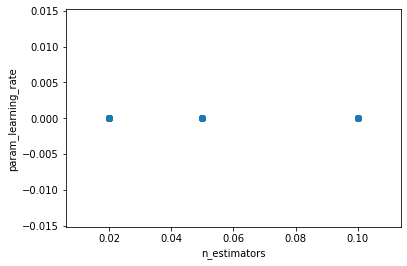

In [56]:
plt.scatter(scores[:,1], scores[:, 0])
plt.xlabel('n_estimators')
plt.ylabel('param_learning_rate')
plt.show()



In [57]:
scores = np.array([[
        cv_results['mean_test_score'],
        cv_results['param_gamma']]])

Text(0, 0.5, 'mean_test_score')

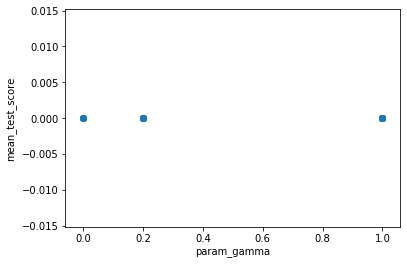

In [58]:
plt.scatter(scores[:,1], scores[:, 0])
plt.xlabel('param_gamma')
plt.ylabel('mean_test_score')

In [59]:
scores

array([[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
         0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.2, 0, 0.2, 0.2, 1, 0.2, 1, 0.2, 0.2, 0.2, 1, 0.2,
         0.2, 1, 1, 0.2, 0, 0, 1, 1, 0]]], dtype=object)

In [60]:
cv_results = pd.DataFrame(grid.cv_results_)

In [61]:
print(cv_results['param_n_estimators'])

0     100
1     100
2     200
3     100
4     100
5     100
6     100
7     150
8     200
9     100
10    200
11    200
12    150
13    150
14    100
15    200
16    200
17    200
18    150
19    200
20    150
21    200
22    150
Name: param_n_estimators, dtype: object


In [62]:
for i in grid.scorer_:
    print(i)

TypeError: '_PredictScorer' object is not iterable